# Performs Pearson's correlation and colocalization analysis between marker pairs for all cells

In [1]:
import pickle
import pandas as pd
import os
import glob
import sys
import seaborn as sns
import numpy as np
from pathlib import Path 
import matplotlib.pyplot as plt
from statannot import add_stat_annotation
from itertools import combinations
from tqdm.notebook import tqdm, trange
from ast import literal_eval
import scipy
import skimage

In [2]:
# Import path
module_path = str(Path.cwd().parents[0])
if module_path not in sys.path:
    sys.path.append(module_path)

module_path = str(Path.cwd().parents[0] / "src")
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
os.chdir('..')
os.chdir('./src')

In [4]:
from my_io import display_list_image, read_tiff_files
from colocalization import generate_pearson_metric_masked
from config import *

In [5]:
# Figures location   
save_path = f"{data_figure}/boxplots/"
if not os.path.exists(save_path):
    os.makedirs(save_path)

### Loading the datasets

In [6]:
pickle_name_temp = f"{data_path_masked_BM}/image_list_BM.pickle"
zoomed_image_list_BM = pickle.load(open(pickle_name_temp, "rb"))

pickle_name_temp = f"{data_path_masked_UC}/image_list_UC.pickle"
zoomed_image_list_UC = pickle.load(open(pickle_name_temp, "rb"))

In [7]:
pickle_name_temp = f"{data_path_masked_BM}/mask_list_BM.pickle"
zoomed_mask_BM = pickle.load(open(pickle_name_temp, "rb"))

pickle_name_temp = f"{data_path_masked_UC}/mask_list_UC.pickle"
zoomed_mask_UC = pickle.load(open(pickle_name_temp, "rb"))

In [8]:
df_path = data_dir / "BM_UC_indices_all.csv"
df_indices = pd.read_csv(df_path)

In [9]:
df_BM = df_indices.loc[df_indices['CellType']=='BM']
df_BM = df_BM.fillna('')
cellList_BM = []
for index, row in df_BM.iterrows(): 
    templist = []
    if row.indices!='':
        templist.append(literal_eval(row.indices))
        cellList_BM.append(list(templist[0]))
    else:
        cellList_BM.append(templist)

In [10]:
df_UC = df_indices.loc[df_indices['CellType']=='UC']
df_UC = df_UC.fillna('')
cellList_UC = [] #empty list
for index, row in df_UC.iterrows(): 
    templist = []
    if row.indices!='':
        templist.append(literal_eval(row.indices))
        cellList_UC.append(list(templist[0]))
    else:
        cellList_UC.append(templist)

In [11]:
list_area_BM = []
list_area_UC = []

for cell in range(len(zoomed_image_list_BM)):       
    mask_temp = zoomed_mask_BM[cell].copy()/255
    area_temp = mask_temp.sum()
    list_area_BM.append(area_temp)

for cell in range(len(zoomed_image_list_UC)):       
    mask_temp = zoomed_mask_UC[cell].copy()/255
    area_temp = mask_temp.sum()
    list_area_UC.append(area_temp)

### Pearson's correlation

In [12]:
def minMaxScaleThreshold(img, thresh):
    img = np.true_divide(img - np.min(img), \
                        np.zeros_like(img) + np.max(img) - np.min(img))
    img[img < thresh] = 0
    
    return img

# apply threshold
def applyThresholdMethod(img, choice):
    threshVal = 0
    
    if choice == 'Otsu':
        threshVal = skimage.filters.threshold_otsu(img)
        
    elif choice == 'Isodata':
        threshVal = skimage.filters.threshold_isodata(img)
        
    elif choice == 'Li':
        threshVal = skimage.filters.threshold_li(img)
        
    elif choice == 'Mean':
        threshVal = skimage.filters.threshold_mean(img)
        
    elif choice == 'Minimum':
        threshVal = skimage.filters.threshold_minimum(img)
        
    elif choice == 'Triangle':
        threshVal = skimage.filters.threshold_triangle(img)
        
    elif choice == 'Yen':
        threshVal = skimage.filters.threshold_yen(img)
        
    else:
        print('Threshold Method not found...')        
    
    return threshVal

In [13]:
threshChoice = 'Otsu'
# minMaxThresh = 0.7

# bounds to select subcellular region
minX = 0.25
maxX = 0.75
minY = 0.25
maxY = 0.75

In [14]:
BM_pairDict = {}
for cell in trange(len(cellList_BM)):
    for entry in combinations(cellList_BM[cell], 2):
        
        # original images
        image1_temp = zoomed_image_list_BM[cell][entry[0]].copy()
        image2_temp = zoomed_image_list_BM[cell][entry[1]].copy()     
        
#         fig, ax = plt.subplots(dpi = 300, facecolor = 'black')
#         ax.imshow(image1_temp)
#         ax.axis('off')
#         continue
                
        # image1_temp = minMaxScaleThreshold(image1_temp, minMaxThresh)
        # image2_temp = minMaxScaleThreshold(image2_temp, minMaxThresh)    
        
        # fig, ax = skimage.filters.try_all_threshold(image1_temp, figsize=(30, 18), verbose=False)
        # # fig.suptitle('Cell #' + str(cell))
        # sys.exit()
        
        # do Otsu, Yen, Triangle, thresholding
        threshVal = applyThresholdMethod(image1_temp, choice = threshChoice)
        image1_temp[image1_temp < threshVal] = 0
        threshVal = applyThresholdMethod(image2_temp, choice = threshChoice)
        image2_temp[image2_temp < threshVal] = 0     
        
        # select subregion of cell instead of whole cell to do correlation
        dimY, dimX = image1_temp.shape
        image1_temp = image1_temp[np.round(minY * dimY).astype(int): np.round(maxY * dimY).astype(int), \
                                 np.round(minX * dimX).astype(int): np.round(maxX * dimX).astype(int)]
        image2_temp = image2_temp[np.round(minY * dimY).astype(int): np.round(maxY * dimY).astype(int), \
                                 np.round(minX * dimX).astype(int): np.round(maxX * dimX).astype(int)]
        
        # fig, ax = plt.subplots(dpi = 300, facecolor = 'black')
        # ax.imshow(image1_temp)
        # ax.axis('off')
        
        metrics_temp = generate_pearson_metric_masked(image1_temp, image2_temp)
        dictKey = channel_names[entry[0]] + '_' + channel_names[entry[1]]
        if not dictKey in BM_pairDict.keys():
            BM_pairDict[dictKey] = []
        BM_pairDict[dictKey].append(metrics_temp) 

  0%|          | 0/32 [00:00<?, ?it/s]

In [15]:
UC_pairDict = {}
for cell in trange(len(cellList_UC)):
    for entry in combinations(cellList_UC[cell], 2):
        image1_temp = zoomed_image_list_UC[cell][entry[0]].copy()
        image2_temp = zoomed_image_list_UC[cell][entry[1]].copy()
        
        # image1_temp = minMaxScaleThreshold(image1_temp, minMaxThresh)
        # image2_temp = minMaxScaleThreshold(image2_temp, minMaxThresh)
        
        # fig, ax = skimage.filters.try_all_threshold(image1_temp, figsize=(30, 18), verbose=False)
        # # fig.suptitle('Cell #' + str(cell))
        # sys.exit()
        
        # do Otsu, Yen, Triangle, thresholding
        threshVal = applyThresholdMethod(image1_temp, choice = threshChoice)
        image1_temp[image1_temp < threshVal] = 0
        threshVal = applyThresholdMethod(image2_temp, choice = threshChoice)
        image2_temp[image2_temp < threshVal] = 0  
        
        # select subregion of cell instead of whole cell to do correlation
        dimY, dimX = image1_temp.shape
        image1_temp = image1_temp[np.round(minY * dimY).astype(int): np.round(maxY * dimY).astype(int), \
                                 np.round(minX * dimX).astype(int): np.round(maxX * dimX).astype(int)]
        image2_temp = image2_temp[np.round(minY * dimY).astype(int): np.round(maxY * dimY).astype(int), \
                                 np.round(minX * dimX).astype(int): np.round(maxX * dimX).astype(int)]
        
        
        metrics_temp = generate_pearson_metric_masked(image1_temp, image2_temp)
        dictKey = channel_names[entry[0]] + '_' + channel_names[entry[1]]
        if not dictKey in UC_pairDict.keys():
            UC_pairDict[dictKey] = []
        UC_pairDict[dictKey].append(metrics_temp) 

  0%|          | 0/35 [00:00<?, ?it/s]

In [16]:
BM_pair_df = pd.DataFrame.from_dict(BM_pairDict.items())
BM_pair_df.columns = ['Marker', 'Pearson']
BM_pair_df = BM_pair_df.explode('Pearson')
BM_pair_df['Cell Type'] = 'BM'

In [17]:
UC_pair_df = pd.DataFrame.from_dict(UC_pairDict.items())
UC_pair_df.columns = ['Marker', 'Pearson']
UC_pair_df = UC_pair_df.explode('Pearson')
UC_pair_df['Cell Type'] = 'UC'

In [18]:
frames = [BM_pair_df, UC_pair_df]
result = pd.concat(frames)
result = result.sort_values(by=['Marker'])

In [19]:
result

,Marker,Pearson,Cell Type
0,ATF6_BetaTubulin,0.831835,BM
45,ATF6_BetaTubulin,0.618239,UC
45,ATF6_BetaTubulin,0.555905,UC
45,ATF6_BetaTubulin,0.401332,UC
45,ATF6_BetaTubulin,0.568432,UC
...,...,...,...
54,TOM20_WGA,0.515275,BM
54,TOM20_WGA,0.360074,BM
54,TOM20_WGA,0.471883,BM
54,TOM20_WGA,0.673273,BM


In [20]:
result['Pearson'] = result['Pearson'].values.astype(float)
result.groupby(["Marker","Cell Type"]).agg({'Pearson': ['min', 'mean', 'median', 'max']})

Pearson                              
                                   min      mean    median       max
Marker             Cell Type                                        
ATF6_BetaTubulin   BM         0.230635  0.638931  0.651492  0.831835
                   UC         0.111629  0.527598  0.532653  0.833342
ATF6_ConcanavalinA BM         0.537429  0.608850  0.606558  0.684853
                   UC         0.400188  0.691459  0.721718  0.858331
ATF6_DAPI          BM        -0.376889  0.075110  0.079387  0.479719
...                                ...       ...       ...       ...
Sortilin_TOM20     UC         0.223506  0.492665  0.467866  0.728453
Sortilin_WGA       BM         0.514945  0.656143  0.663811  0.809660
                   UC         0.571951  0.666756  0.636943  0.791373
TOM20_WGA          BM         0.305270  0.557022  0.545052  0.809731
                   UC         0.298807  0.458673  0.405488  0.724908

[110 rows x 4 columns]

  0%|          | 0/55 [00:00<?, ?it/s]

(array([15.,  2.,  2.,  2.,  2.,  1.,  1.,  0.,  3.,  1.,  5.,  3.,  3.,
         0.,  1.,  1.,  4.,  3.,  3.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95]),
 <BarContainer object of 19 artists>)

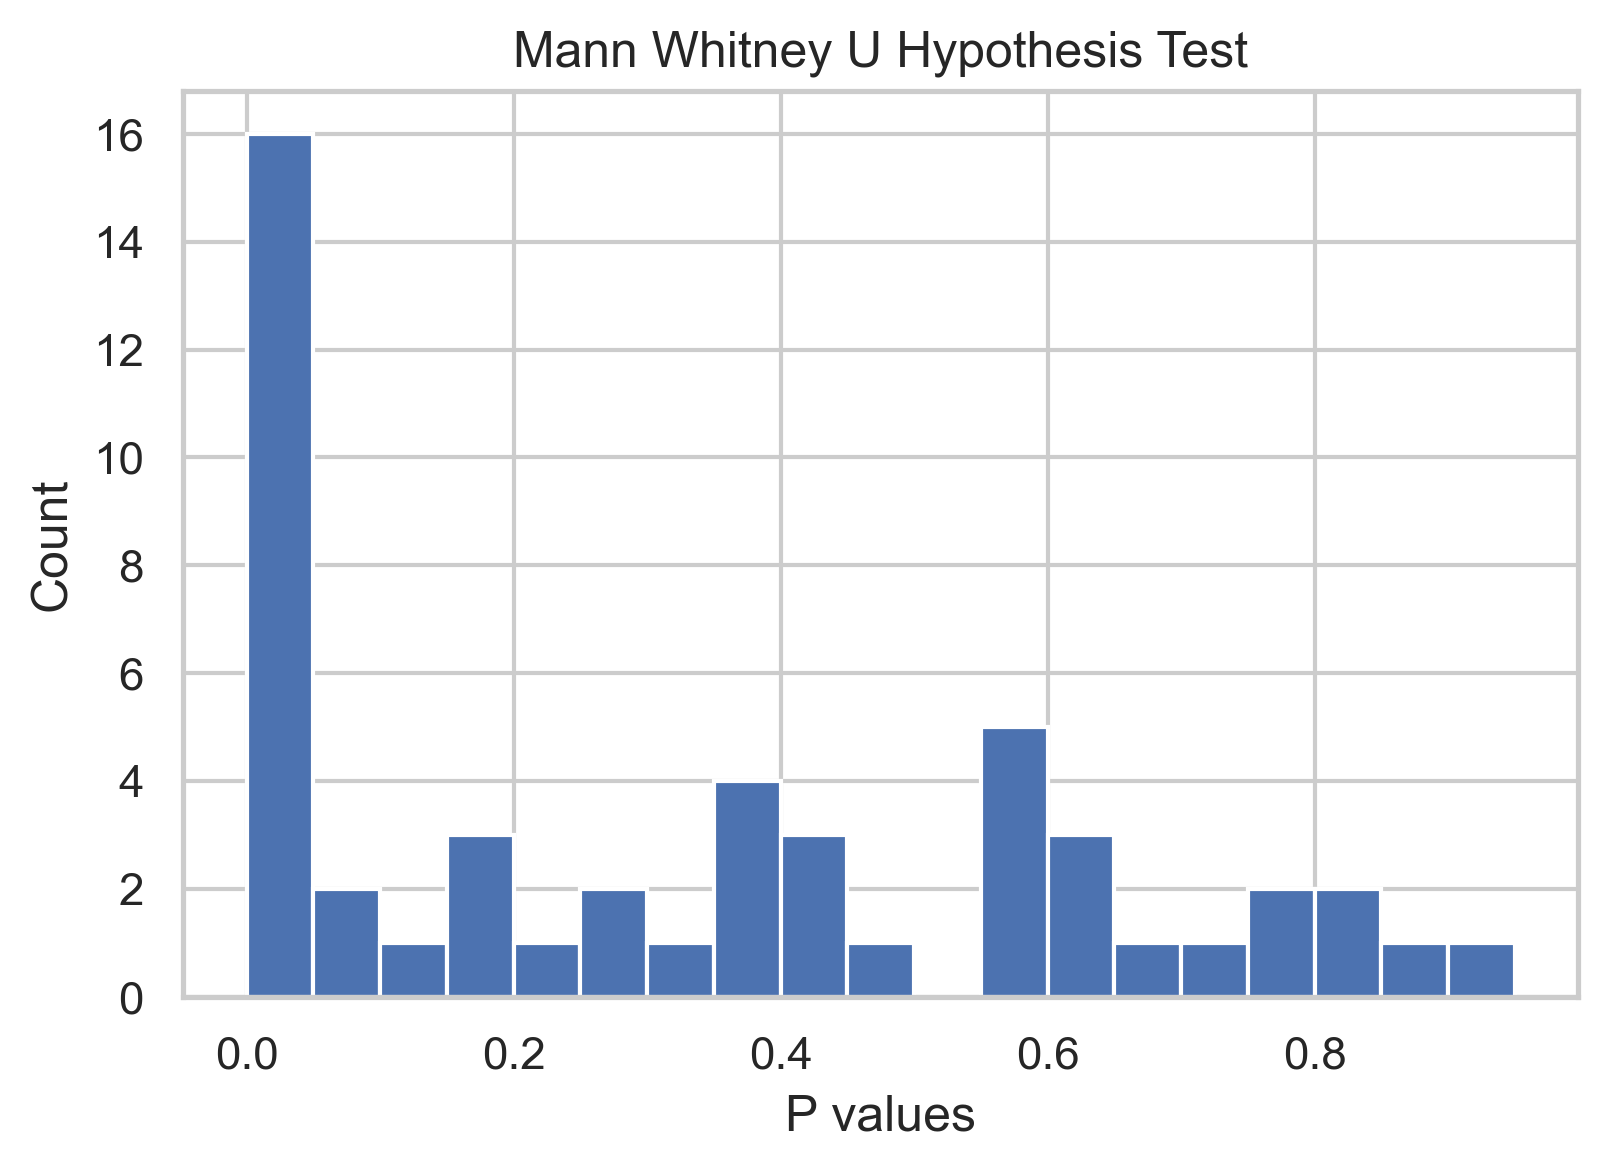

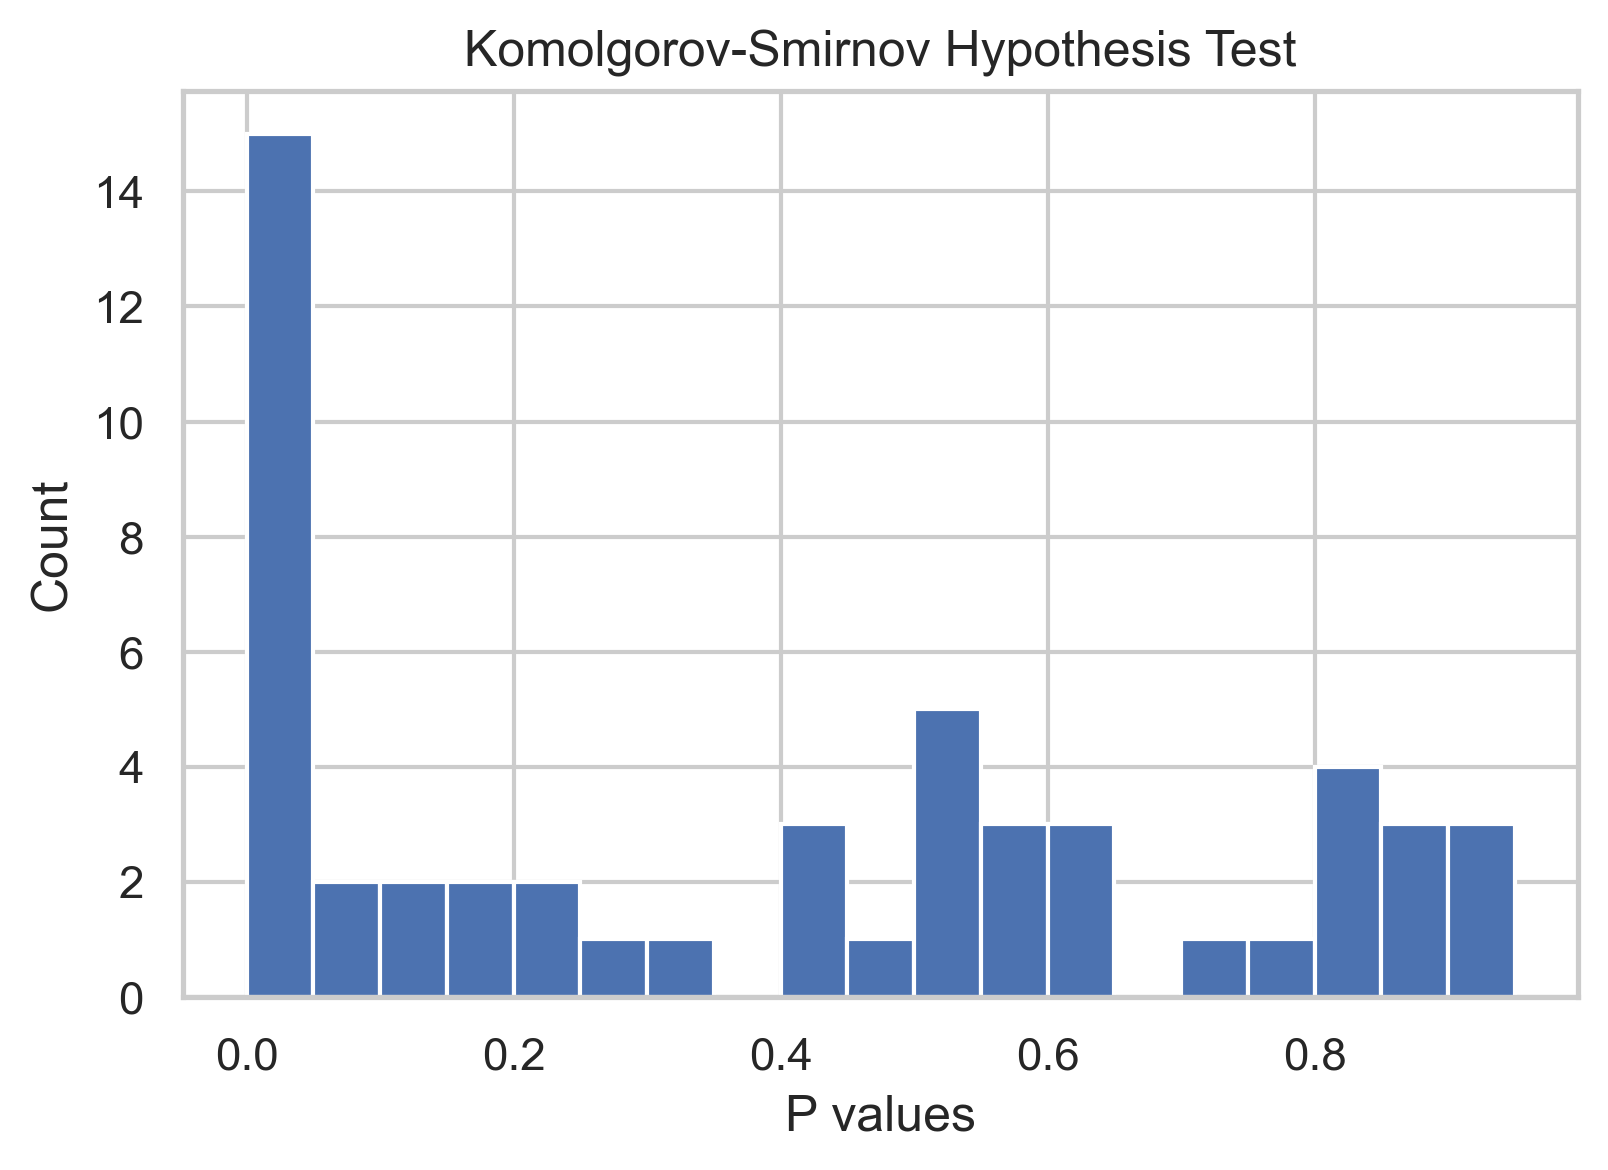

In [21]:
sns.set_theme(style="whitegrid")

data = result

data['Pearson'] = data['Pearson'].values.astype(float)

x = "Marker"
y = "Pearson"
hue = "Cell Type"
hue_order=['BM', 'UC']
channel_pairs = data["Marker"].unique()

# stat test BM vs UC within each marker
pVals = pd.DataFrame(columns = ['MannWhitney', 'KS'])
for ii, markerName in enumerate(tqdm(channel_pairs)):
    
    bm = data.loc[(data['Marker'] == markerName) & (data['Cell Type'] == 'BM')]['Pearson'].values.astype(float)
    uc = data.loc[(data['Marker'] == markerName) & (data['Cell Type'] == 'UC')]['Pearson'].values.astype(float)
    
    res1 = scipy.stats.mannwhitneyu(bm, uc, alternative = 'two-sided')
    res2 = scipy.stats.ks_2samp(bm, uc, alternative = 'two-sided')
    
    pVals = pVals.append(pd.DataFrame(np.array([res1.pvalue, res2.pvalue]).reshape(1, -1), columns = ['MannWhitney', 'KS']))
    
pVals = pVals.reset_index(drop = True)
    
# plot histogram of p values
fig, ax = plt.subplots(dpi = 300)
ax.set_xlabel('P values')
ax.set_ylabel('Count')
ax.set_title('Mann Whitney U Hypothesis Test')
ax.hist(pVals['MannWhitney'], bins = np.arange(0, 1, 0.05))

fig, ax = plt.subplots(dpi = 300)
ax.set_xlabel('P values')
ax.set_ylabel('Count')
ax.set_title('Komolgorov-Smirnov Hypothesis Test')
ax.hist(pVals['KS'], bins = np.arange(0, 1, 0.05))

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Nucleolin_TOM20_BM v.s. Nucleolin_TOM20_UC: Mann-Whitney-Wilcoxon test two-sided, P_val=7.552e-01 U_stat=1.040e+02
Nucleolin_WGA_BM v.s. Nucleolin_WGA_UC: Mann-Whitney-Wilcoxon test two-sided, P_val=3.168e-01 U_stat=2.200e+01
Nucleolin_Sortilin_BM v.s. Nucleolin_Sortilin_UC: Mann-Whitney-Wilcoxon test two-sided, P_val=3.175e-04 U_stat=1.880e+02
DAPI_HSP60_BM v.s. DAPI_HSP60_UC: Mann-Whitney-Wilcoxon test two-sided, P_val=8.066e-01 U_stat=7.300e+01
DAPI_GOLPH4_BM v.s. DAPI_GOLPH4_UC: Mann-Whitney-Wilcoxon test two-sided, P_val=5.766e-01 U_stat=1.200e+02
DAPI_Nucleolin_BM v.s. DAPI_Nucleolin_UC: Mann-Whitney-Wilcoxon test two-sided, P_val=3.847e-05 U_stat=3.220e+02
DAPI_Phalloidin_BM v.s. DAPI_Phalloidin_UC: Mann-Whitney-Wilcoxon test two-sided, P_val=5.944e-04 U_stat=6.000e+00
DAPI_Sortilin_BM v.s. DAPI_Sortilin_UC: Mann-Whit

C:\Users\NZHANG~1\AppData\Local\Temp/ipykernel_68240/3591511291.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 32)


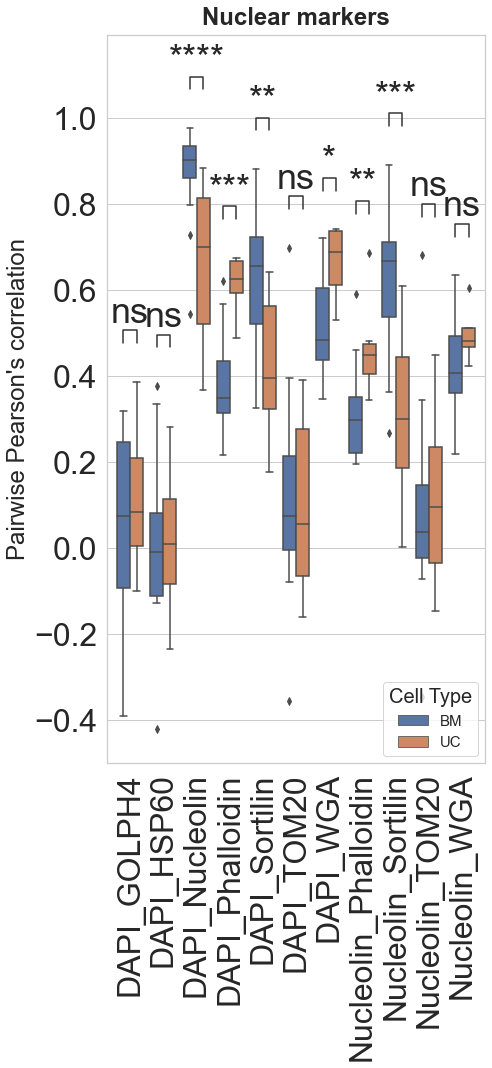

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Phalloidin_Sortilin_BM v.s. Phalloidin_Sortilin_UC: Mann-Whitney-Wilcoxon test two-sided, P_val=3.122e-02 U_stat=1.000e+01
Phalloidin_TOM20_BM v.s. Phalloidin_TOM20_UC: Mann-Whitney-Wilcoxon test two-sided, P_val=9.636e-01 U_stat=3.500e+01
Phalloidin_WGA_BM v.s. Phalloidin_WGA_UC: Mann-Whitney-Wilcoxon test two-sided, P_val=3.579e-01 U_stat=1.600e+01
BetaTubulin_WGA_BM v.s. BetaTubulin_WGA_UC: Mann-Whitney-Wilcoxon test two-sided, P_val=1.971e-01 U_stat=3.200e+01
BetaTubulin_DAPI_BM v.s. BetaTubulin_DAPI_UC: Mann-Whitney-Wilcoxon test two-sided, P_val=2.039e-01 U_stat=6.300e+01
BetaTubulin_ConcanavalinA_BM v.s. BetaTubulin_ConcanavalinA_UC: Mann-Whitney-Wilcoxon test two-sided, P_val=4.127e-01 U_stat=1.400e+01
BetaTubulin_GOLPH4_BM v.s. BetaTubulin_GOLPH4_UC: Mann-Whitney-Wilcoxon test two-sided, P_val=2.187e-02 U_stat=1.240

C:\Users\NZHANG~1\AppData\Local\Temp/ipykernel_68240/3591511291.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 32)


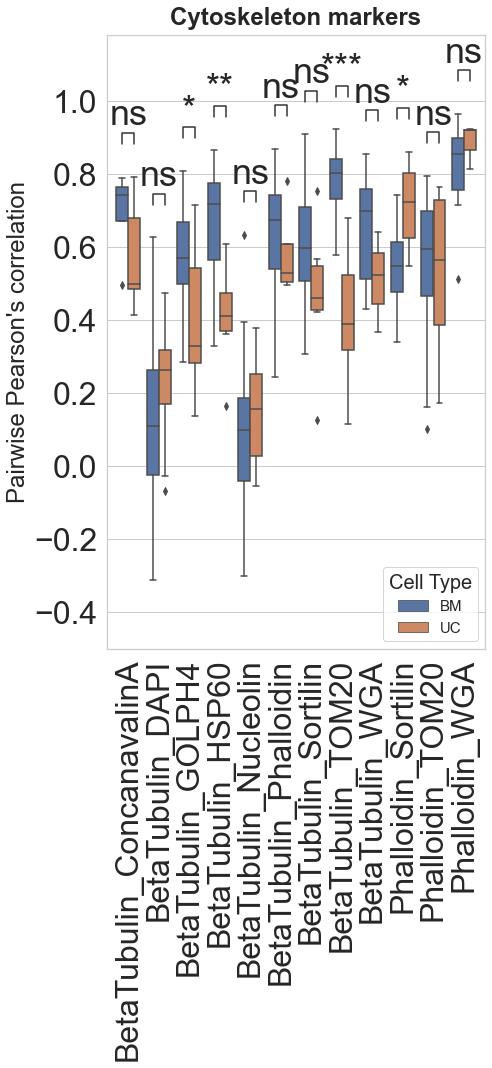

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

ATF6_WGA_BM v.s. ATF6_WGA_UC: Mann-Whitney-Wilcoxon test two-sided, P_val=1.026e-02 U_stat=3.000e+00
ConcanavalinA_DAPI_BM v.s. ConcanavalinA_DAPI_UC: Mann-Whitney-Wilcoxon test two-sided, P_val=6.042e-01 U_stat=2.200e+01
ConcanavalinA_GOLPH4_BM v.s. ConcanavalinA_GOLPH4_UC: Mann-Whitney-Wilcoxon test two-sided, P_val=1.986e-01 U_stat=9.000e+00
ConcanavalinA_HSP60_BM v.s. ConcanavalinA_HSP60_UC: Mann-Whitney-Wilcoxon test two-sided, P_val=3.677e-01 U_stat=1.000e+01
ConcanavalinA_Nucleolin_BM v.s. ConcanavalinA_Nucleolin_UC: Mann-Whitney-Wilcoxon test two-sided, P_val=6.828e-01 U_stat=1.900e+01
ConcanavalinA_Phalloidin_BM v.s. ConcanavalinA_Phalloidin_UC: Mann-Whitney-Wilcoxon test two-sided, P_val=1.714e-01 U_stat=5.000e+00
ConcanavalinA_Sortilin_BM v.s. ConcanavalinA_Sortilin_UC: Mann-Whitney-Wilcoxon test two-sided, P_val=

C:\Users\NZHANG~1\AppData\Local\Temp/ipykernel_68240/3591511291.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 32)


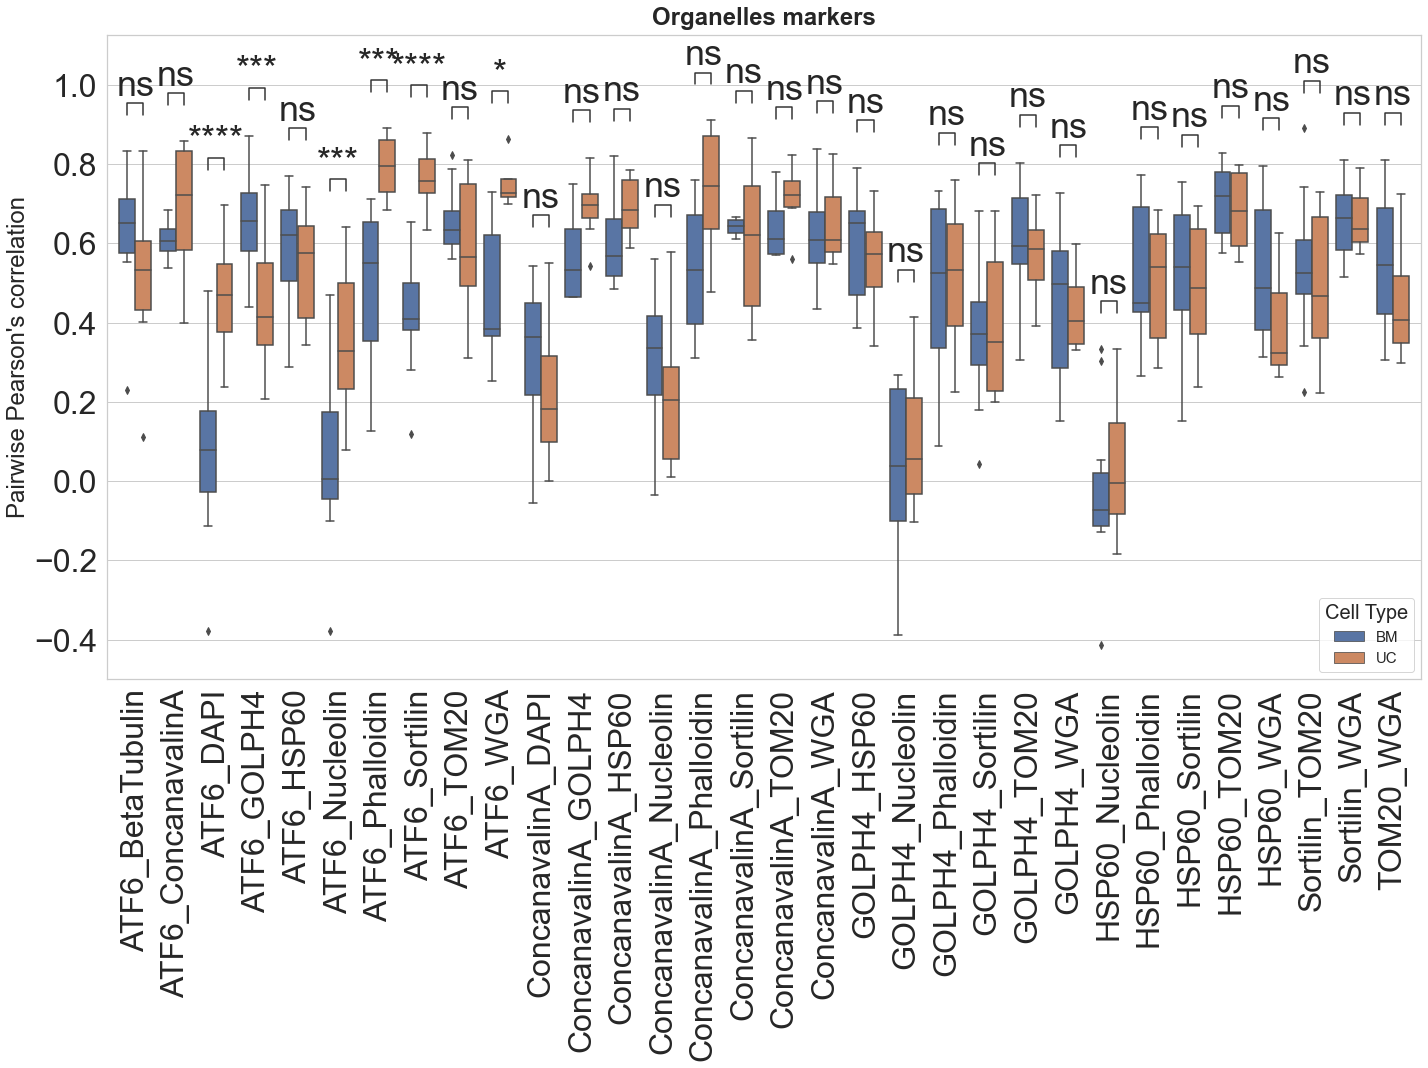

In [22]:
# plot boxplot of pearson's correlation with statistical significance
# separate boxplots into categories: cytoskeletal, organelles, nucleus
# nucleus: DAPI, nuc
# cytoskeletal: Beta Tubulin, Phalloidin 
# organelles: ATF6, GOLPH4, Sor, HSP60, TOM20, Conc A, WGA
markerGroups = {}
markerGroups['Nuclear'] = ['DAPI', 'Nucleolin']
markerGroups['Cytoskeleton'] = ['BetaTubulin', 'Phalloidin']
markerGroups['Organelles'] = ['ATF6', 'GOLPH4', 'Sortilin', 'HSP60', 'TOM20', 'ConcanavalinA', 'WGA']

tbl = pd.DataFrame()
for group, markers in markerGroups.items():

    if group == 'Organelles':
        plt.figure(figsize = (20, 15))
        
    else:
        plt.figure(figsize=(7, 15))

    # slice out group
    box_pairs=[((chan, "BM"), (chan, "UC")) for chan in channel_pairs \
               if chan.split('_')[0] in markers]

    idxSelect = []
    for ii, _ in enumerate(data.index):
        marker = data['Marker'].iloc[ii]
        marker = marker.split('_')[0]
        if marker in markers:
            idxSelect.append(ii)
            
    dataSub = data.iloc[idxSelect, :]

    g = sns.boxplot(data=dataSub, hue=hue, x=x, y=y) 
    g.set_ylim(-0.5, 1)
    locs, labels = plt.xticks()
    plt.setp(labels, rotation=90)

    ax, stats = add_stat_annotation(g, data=dataSub, x=x, y=y, hue=hue, box_pairs=box_pairs,
                        test='Mann-Whitney', loc='inside', verbose=2, comparisons_correction =None, fontsize = 36)
    g.figure.axes[-1].yaxis.label.set_size(20)
    g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 32, rotation=90)
    g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 32)
    g.set_title(f"" + group + " markers",fontsize= 24, pad=10, fontweight ="bold")
    g.set_xlabel("",fontsize=1)
    g.set_ylabel("Pairwise Pearson's correlation",fontsize=24)
    handles, labels = g.get_legend_handles_labels()
    # g.legend(handles[:2], labels[:2], title='Cell Type', fontsize=15, title_fontsize=20, loc='center left', bbox_to_anchor=(1, 0.5))
    g.legend(handles[:2], labels[:2], title='Cell Type', fontsize=15, title_fontsize=20, loc = 'lower right')        
    plt.tight_layout()
    image_path_png = save_path+"/pearson_BM_UC_" + group + ".png"
    plt.savefig(image_path_png, bbox_inches="tight")
    plt.show()
    
    # format table for supplementary
    dataSub = dataSub.groupby(['Cell Type', "Marker"]).agg({'Pearson': ['min', 'mean', 'median', 'max']})
    # concat BM and UC
    dataSub_BM = dataSub.loc[dataSub.index.get_level_values(0) == 'BM']
    dataSub_BM = dataSub_BM.droplevel(0)
    dataSub_BM.columns = ['_'.join(pair) + '_BM' for pair in dataSub_BM.columns]

    dataSub_UC = dataSub.loc[dataSub.index.get_level_values(0) == 'UC']
    dataSub_UC = dataSub_UC.droplevel(0)
    dataSub_UC.columns = ['_'.join(pair) + '_UC' for pair in dataSub_UC.columns]
    
    dataSub = pd.concat([dataSub_BM, dataSub_UC], axis = 1)
    
    # add stats test results
    dfStat = pd.DataFrame()
    for jj, stat in enumerate(stats): # each stat result
        res = stat.__dict__
        markerComp = res['box1'][0]
        pval = res['pval']
        uStat = res['stat']
        
        dfSub = {'Marker': markerComp, 
                'P_val': pval,
                'U_stat': uStat}
        dfSub = pd.DataFrame(dfSub, index = [0])
        dfStat = pd.concat([dfStat, dfSub])
        
    dfStat.set_index('Marker', inplace = True)
        
    # merge stats 
    dataSub = dataSub.merge(dfStat, how = 'outer', left_index = True, right_index = True)
    
    tbl = pd.concat([tbl, dataSub]) # ordered by group
            
tbl.reset_index(drop = False, inplace = True)
# export table to excel
fileOut = os.path.join(save_path, 'pearsons_table.xlsx')
tbl.to_excel(fileOut)

### Colocalization

In [23]:
BM_colocDict = {}
for cell in trange(len(cellList_BM)):
    for entry in combinations(cellList_BM[cell], 2):
        image1_temp = zoomed_image_list_BM[cell][entry[0]].copy()
        # image1_temp = (image1_temp >= np.quantile(image1_temp, 0.9)).astype(np.int8)        
        image2_temp = zoomed_image_list_BM[cell][entry[1]].copy()
        # image2_temp = (image2_temp >= np.quantile(image2_temp, 0.9)).astype(np.int8)
        
        # do Otsu, Yen, Triangle, thresholding
        threshVal = applyThresholdMethod(image1_temp, choice = threshChoice)
        image1_temp[image1_temp < threshVal] = 0
        threshVal = applyThresholdMethod(image2_temp, choice = threshChoice)
        image2_temp[image2_temp < threshVal] = 0     
        
        # select subregion of cell instead of whole cell to do correlation
        dimY, dimX = image1_temp.shape
        image1_temp = image1_temp[np.round(minY * dimY).astype(int): np.round(maxY * dimY).astype(int), \
                                 np.round(minX * dimX).astype(int): np.round(maxX * dimX).astype(int)]
        image2_temp = image2_temp[np.round(minY * dimY).astype(int): np.round(maxY * dimY).astype(int), \
                                 np.round(minX * dimX).astype(int): np.round(maxX * dimX).astype(int)]
        
        image_temp_all = (image2_temp * image1_temp)/list_area_BM[cell]
        metrics_temp = image_temp_all.sum()
        dictKey = channel_names[entry[0]] + '_' + channel_names[entry[1]]
        if not dictKey in BM_colocDict.keys():
            BM_colocDict[dictKey] = []
        BM_colocDict[dictKey].append(metrics_temp) 

  0%|          | 0/32 [00:00<?, ?it/s]

In [24]:
UC_colocDict = {}
for cell in trange(len(cellList_UC)):
    for entry in combinations(cellList_UC[cell], 2):
        image1_temp = zoomed_image_list_UC[cell][entry[0]].copy()
        # image1_temp = (image1_temp >= np.quantile(image1_temp, 0.9)).astype(np.int8)        
        image2_temp = zoomed_image_list_UC[cell][entry[1]].copy()
        # image2_temp = (image2_temp >= np.quantile(image2_temp, 0.9)).astype(np.int8)
        
        # do Otsu, Yen, Triangle, thresholding
        threshVal = applyThresholdMethod(image1_temp, choice = threshChoice)
        image1_temp[image1_temp < threshVal] = 0
        threshVal = applyThresholdMethod(image2_temp, choice = threshChoice)
        image2_temp[image2_temp < threshVal] = 0     
        
        # select subregion of cell instead of whole cell to do correlation
        dimY, dimX = image1_temp.shape
        image1_temp = image1_temp[np.round(minY * dimY).astype(int): np.round(maxY * dimY).astype(int), \
                                 np.round(minX * dimX).astype(int): np.round(maxX * dimX).astype(int)]
        image2_temp = image2_temp[np.round(minY * dimY).astype(int): np.round(maxY * dimY).astype(int), \
                                 np.round(minX * dimX).astype(int): np.round(maxX * dimX).astype(int)]
        
        image_temp_all = (image2_temp * image1_temp)/list_area_UC[cell]
        metrics_temp = image_temp_all.sum()
        dictKey = channel_names[entry[0]] + '_' + channel_names[entry[1]]
        if not dictKey in UC_colocDict.keys():
            UC_colocDict[dictKey] = []
        UC_colocDict[dictKey].append(metrics_temp) 

  0%|          | 0/35 [00:00<?, ?it/s]

In [25]:
BM_coloc_df = pd.DataFrame.from_dict(BM_colocDict.items())
BM_coloc_df.columns = ['Marker', 'Coloc']
BM_coloc_df = BM_coloc_df.explode('Coloc')
BM_coloc_df['Cell Type'] = 'BM'

In [26]:
UC_coloc_df = pd.DataFrame.from_dict(UC_colocDict.items())
UC_coloc_df.columns = ['Marker', 'Coloc']
UC_coloc_df = UC_coloc_df.explode('Coloc')
UC_coloc_df['Cell Type'] = 'UC'

In [27]:
frames = [BM_coloc_df, UC_coloc_df]
coloc_df = pd.concat(frames)
coloc_df = coloc_df.sort_values(by=['Marker'])

In [28]:
coloc_df['Coloc'] = coloc_df['Coloc'].values.astype(float)
coloc_df.groupby(["Marker","Cell Type"]).agg({'Coloc': ['min', 'mean', 'median', 'max']})

Coloc                            \
                                     min         mean       median   
Marker             Cell Type                                         
ATF6_BetaTubulin   BM          22.568486   708.625109   626.888852   
                   UC         172.379604   916.139152   398.691043   
ATF6_ConcanavalinA BM         269.451062   547.075022   554.451078   
                   UC         550.782903  1884.630148  1481.035296   
ATF6_DAPI          BM          22.018841   264.164300   197.371499   
...                                  ...          ...          ...   
Sortilin_TOM20     UC          23.911477   241.812148   146.399580   
Sortilin_WGA       BM         435.873318  2620.079855  1967.311825   
                   UC         470.455516   905.651750   933.703671   
TOM20_WGA          BM         107.731514   820.281253   552.251509   
                   UC         537.300140  1046.131053   794.207055   

                                           
                                      max  
Marker             Cell Type               
ATF6_BetaTubulin   BM         2076.695353  
                   UC         3435.677250  
ATF6_ConcanavalinA BM          809.946870  
                   UC         3886.525885  
ATF6_DAPI          BM          740.250471  
...                                   ...  
Sortilin_TOM20     UC          966.051681  
Sortilin_WGA       BM         8479.497579  
                   UC         1312.796064  
TOM20_WGA          BM         3449.486962  
                   UC         2058.809960  

[110 rows x 4 columns]

C:\Users\NZHANG~1\AppData\Local\Temp/ipykernel_68240/331481959.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataSub['Coloc'] = dataSub['Coloc'].values.astype(float)


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Nucleolin_TOM20_BM v.s. Nucleolin_TOM20_UC: Mann-Whitney-Wilcoxon test two-sided, P_val=6.929e-01 U_stat=1.220e+02
Nucleolin_WGA_BM v.s. Nucleolin_WGA_UC: Mann-Whitney-Wilcoxon test two-sided, P_val=6.353e-01 U_stat=2.800e+01
Nucleolin_Sortilin_BM v.s. Nucleolin_Sortilin_UC: Mann-Whitney-Wilcoxon test two-sided, P_val=9.839e-04 U_stat=1.810e+02
DAPI_HSP60_BM v.s. DAPI_HSP60_UC: Mann-Whitney-Wilcoxon test two-sided, P_val=3.167e-02 U_stat=3.800e+01
DAPI_GOLPH4_BM v.s. DAPI_GOLPH4_UC: Mann-Whitney-Wilcoxon test two-sided, P_val=7.053e-01 U_stat=1.470e+02
DAPI_Nucleolin_BM v.s. DAPI_Nucleolin_UC: Mann-Whitney-Wilcoxon test two-sided, P_val=3.069e-01 U_stat=2.160e+02
DAPI_Phalloidin_BM v.s. DAPI_Phalloidin_UC: Mann-Whitney-Wilcoxon test two-sided, P_val=6.235e-02 U_stat=2.400e+01
DAPI_Sortilin_BM v.s. DAPI_Sortilin_UC: Mann-Whit

C:\Users\NZHANG~1\AppData\Local\Temp/ipykernel_68240/331481959.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 24)


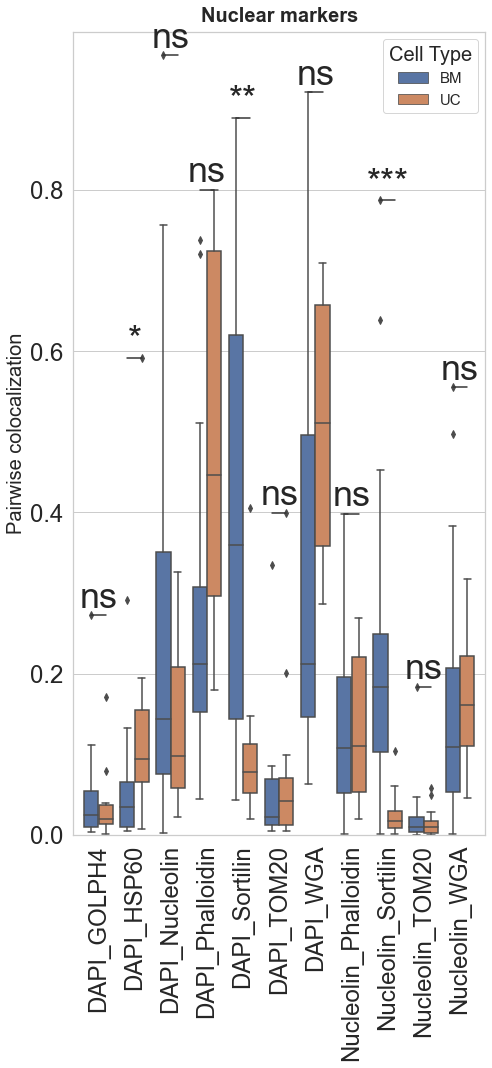

C:\Users\NZHANG~1\AppData\Local\Temp/ipykernel_68240/331481959.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataSub['Coloc'] = dataSub['Coloc'].values.astype(float)


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Phalloidin_Sortilin_BM v.s. Phalloidin_Sortilin_UC: Mann-Whitney-Wilcoxon test two-sided, P_val=9.341e-02 U_stat=4.600e+01
Phalloidin_TOM20_BM v.s. Phalloidin_TOM20_UC: Mann-Whitney-Wilcoxon test two-sided, P_val=9.636e-01 U_stat=3.700e+01
Phalloidin_WGA_BM v.s. Phalloidin_WGA_UC: Mann-Whitney-Wilcoxon test two-sided, P_val=3.579e-01 U_stat=1.600e+01
BetaTubulin_WGA_BM v.s. BetaTubulin_WGA_UC: Mann-Whitney-Wilcoxon test two-sided, P_val=4.706e-02 U_stat=3.700e+01
BetaTubulin_DAPI_BM v.s. BetaTubulin_DAPI_UC: Mann-Whitney-Wilcoxon test two-sided, P_val=6.488e-01 U_stat=8.000e+01
BetaTubulin_ConcanavalinA_BM v.s. BetaTubulin_ConcanavalinA_UC: Mann-Whitney-Wilcoxon test two-sided, P_val=9.048e-01 U_stat=1.100e+01
BetaTubulin_GOLPH4_BM v.s. BetaTubulin_GOLPH4_UC: Mann-Whitney-Wilcoxon test two-sided, P_val=7.777e-03 U_stat=1.310

C:\Users\NZHANG~1\AppData\Local\Temp/ipykernel_68240/331481959.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 24)


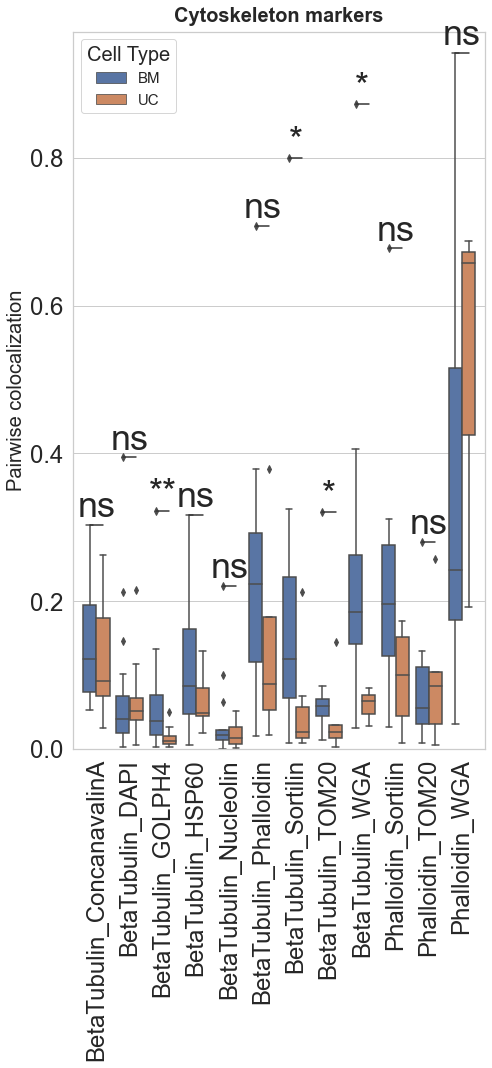

C:\Users\NZHANG~1\AppData\Local\Temp/ipykernel_68240/331481959.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataSub['Coloc'] = dataSub['Coloc'].values.astype(float)


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

ATF6_WGA_BM v.s. ATF6_WGA_UC: Mann-Whitney-Wilcoxon test two-sided, P_val=1.026e-02 U_stat=3.000e+00
ConcanavalinA_DAPI_BM v.s. ConcanavalinA_DAPI_UC: Mann-Whitney-Wilcoxon test two-sided, P_val=7.105e-01 U_stat=1.500e+01
ConcanavalinA_GOLPH4_BM v.s. ConcanavalinA_GOLPH4_UC: Mann-Whitney-Wilcoxon test two-sided, P_val=7.105e-01 U_stat=1.500e+01
ConcanavalinA_HSP60_BM v.s. ConcanavalinA_HSP60_UC: Mann-Whitney-Wilcoxon test two-sided, P_val=8.081e-03 U_stat=1.000e+00
ConcanavalinA_Nucleolin_BM v.s. ConcanavalinA_Nucleolin_UC: Mann-Whitney-Wilcoxon test two-sided, P_val=5.697e-01 U_stat=2.000e+01
ConcanavalinA_Phalloidin_BM v.s. ConcanavalinA_Phalloidin_UC: Mann-Whitney-Wilcoxon test two-sided, P_val=9.143e-01 U_stat=1.100e+01
ConcanavalinA_Sortilin_BM v.s. ConcanavalinA_Sortilin_UC: Mann-Whitney-Wilcoxon test two-sided, P_val=

C:\Users\NZHANG~1\AppData\Local\Temp/ipykernel_68240/331481959.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 24)


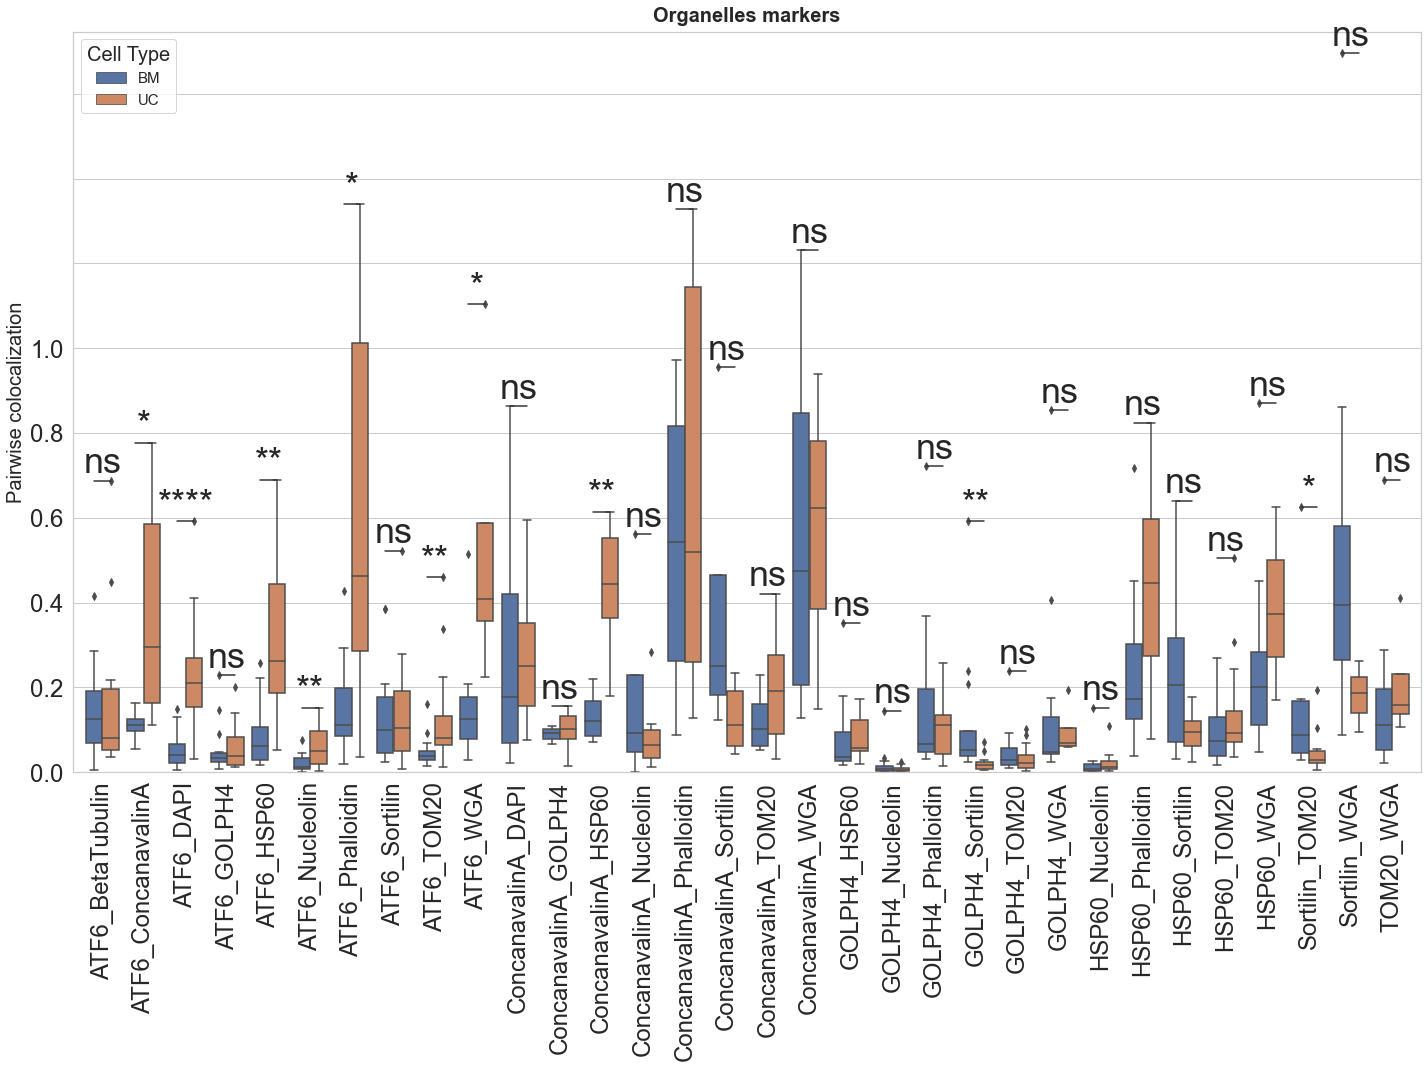

In [29]:
sns.set_theme(style="whitegrid")

tbl = pd.DataFrame()
for group, markers in markerGroups.items():

    # plt.figure(figsize=(10, 13))
    # plt.title('Colocalization between markers')
    if group == 'Organelles':
        plt.figure(figsize = (20, 15))

    else:
        plt.figure(figsize=(7, 15))

    idxSelect = []
    for ii, _ in enumerate(coloc_df.index):
        marker = coloc_df['Marker'].iloc[ii]
        marker = marker.split('_')[0]
        if marker in markers:
            idxSelect.append(ii)
            
    dataSub = coloc_df.iloc[idxSelect, :]

    dataSub['Coloc'] = dataSub['Coloc'].values.astype(float)

    x = "Marker"
    y = "Coloc"
    hue = "Cell Type"
    hue_order=['BM', 'UC']
    channel_pairs = dataSub["Marker"].unique()
    
    # slice out group
    box_pairs=[((chan, "BM"), (chan, "UC")) for chan in channel_pairs \
               if chan.split('_')[0] in markers]

    g = sns.boxplot(data=dataSub, hue=hue, x=x, y=y)
    g.set_ylim(0, 1)
    ax, stats = add_stat_annotation(g, data=dataSub, x=x, y=y, hue=hue, box_pairs=box_pairs,
                        test='Mann-Whitney', loc='inside', verbose=2, comparisons_correction=None, fontsize = 36)
    g.figure.axes[-1].yaxis.label.set_size(20)
    g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 24, rotation=90)
    g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 24)
    g.set_title(f"" + group + " markers", fontsize= 20, pad=10, fontweight ="bold")
    g.set_xlabel("",fontsize=1)
    g.set_ylabel("Pairwise colocalization",fontsize=20)
    handles, labels = g.get_legend_handles_labels()
    # g.legend(handles[:2], labels[:2], title='Cell Type', fontsize=15, title_fontsize=20, loc='center left', bbox_to_anchor=(1, 0.5))
    g.legend(handles[:2], labels[:2], title='Cell Type', fontsize=15, title_fontsize=20)
    plt.tight_layout()
    image_path_png = save_path+"/colocalization_BM_UC_" + group + ".png"
    plt.savefig(image_path_png, bbox_inches="tight")
    plt.show()
    
    # format table for supplementary
    dataSub = dataSub.groupby(['Cell Type', "Marker"]).agg({'Coloc': ['min', 'mean', 'median', 'max']})
    # concat BM and UC
    dataSub_BM = dataSub.loc[dataSub.index.get_level_values(0) == 'BM']
    dataSub_BM = dataSub_BM.droplevel(0)
    dataSub_BM.columns = ['_'.join(pair) + '_BM' for pair in dataSub_BM.columns]

    dataSub_UC = dataSub.loc[dataSub.index.get_level_values(0) == 'UC']
    dataSub_UC = dataSub_UC.droplevel(0)
    dataSub_UC.columns = ['_'.join(pair) + '_UC' for pair in dataSub_UC.columns]
    
    dataSub = pd.concat([dataSub_BM, dataSub_UC], axis = 1)
    
    # add stats test results
    dfStat = pd.DataFrame()
    for jj, stat in enumerate(stats): # each stat result
        res = stat.__dict__
        markerComp = res['box1'][0]
        pval = res['pval']
        uStat = res['stat']
        
        dfSub = {'Marker': markerComp, 
                'P_val': pval,
                'U_stat': uStat}
        dfSub = pd.DataFrame(dfSub, index = [0])
        dfStat = pd.concat([dfStat, dfSub])
        
    dfStat.set_index('Marker', inplace = True)
        
    # merge stats 
    dataSub = dataSub.merge(dfStat, how = 'outer', left_index = True, right_index = True)
    
    tbl = pd.concat([tbl, dataSub]) # ordered by group
            
tbl.reset_index(drop = False, inplace = True)
# export table to excel
fileOut = os.path.join(save_path, 'coloc_table.xlsx')
tbl.to_excel(fileOut)